A [continuous time Markov chain](https://en.wikipedia.org/wiki/Markov_chain) is used to model a system with a set of states and where rates of changes from one state to another are known.

A common example of this is what is denoted as an **M/M/c/K** queue, this corresponds to a system with **M**arkovian arrival and service distributions, **c** servers and a total capacity for **K** individuals.

With an arrival rate \\(\lambda\\) and a service rate \\(\mu\\) then we can write down a matrix \\(Q\\) that essentially defines our chain.

Illustrating this with a concrete example an **M/M/1/3** queue can be in 1 of 4 states: 0, 1, 2 or 3 individuals. The rate at which the system goes from 2 to 3 individuals is \\(\lambda\\) and the rate of which it goes from 2 to 1 is \\(\mu\\). The matrix \\(Q\\) that captures this is:


\\[
Q = 
\begin{pmatrix}
    -\lambda          & \lambda           & 0                 & 0 \\
    \mu               & -(\lambda + \mu) &  \lambda          & 0 \\
    0                 & \mu               & -(\lambda + \mu) & \lambda\\
    0                 & 0                 & \mu               & -\mu \\
\end{pmatrix}
\\]

what is used to study this types of stochastic systems is a probability vector \\(\pi\\) which keeps track of the probability of the system being in a given state. For our example, \\(\pi=(1, 0, 0, 0)\\) would imply that there is 0 individuals in the system, \\(\pi=(1/4, 1/4, 1/4, 1/4)\\) implies that there is an equal chance of being in any given state.

The relationship between \\(Q\\) and \\(\pi\\) is given by the following differential equation:

\\[
    \frac{d\pi}{dt} = \pi Q
\\]

This is an example of a linear homogenous differential equation.

Let us illustrate some of this with some code. First let us build a function that gives us a \\(Q\\) for given parameters:

In [1]:
import numpy as np

def get_transition_matrix(
    number_of_servers,
    total_capacity,
    arrival_rate,
    service_rate
):
    """
    Obtain Q for an M/M/c/K queue with given parameters:
    
    - number_of_servers: c
    - total_capacity: K
    - arrival_rate: lambda
    - service_rate: mu
    """
    Q = np.zeros((total_capacity + 1, total_capacity + 1))
    
    for i in range(total_capacity + 1):
        total_rate = 0
        
        if i < total_capacity:
            Q[i, i + 1] = arrival_rate
            total_rate += Q[i, i + 1]
        
        if i > 0:
            Q[i, i - 1] = min(i, number_of_servers) * service_rate
            total_rate += Q[i, i - 1]
        
        Q[i, i] = - total_rate
        
    return Q


# A test
expected_Q_MM23 = np.array([[-1.,  1.,  0.,  0.],
                            [ 2., -3.,  1.,  0.],
                            [ 0.,  4., -5.,  1.],
                            [ 0.,  0.,  4., -4.]])
assert np.array_equal(
    get_transition_matrix(
        number_of_servers=2, 
        total_capacity=3, 
        arrival_rate=1, 
        service_rate=2),
    expected_Q_MM23
)

In [2]:
Q = get_transition_matrix(number_of_servers=1, total_capacity=3, arrival_rate=1, service_rate=2)
Q

array([[-1.,  1.,  0.,  0.],
       [ 2., -3.,  1.,  0.],
       [ 0.,  2., -3.,  1.],
       [ 0.,  0.,  2., -2.]])

What specifically is of interest is the steady state of a continuous Markov chain, in other words a state for which the derivative is 0:

\\[
    \frac{d\pi}{dt} = \pi Q = 0
\\]

We can easily check if any given state is a steady state:

In [3]:
def is_steady_state(state, Q):
    """
    Returns a boolean as to whether a given state is a steady 
    state of the Markov chain corresponding to the matrix Q
    """
    return np.allclose((state @ Q), 0)

state = np.array([1 / 4, 1 / 4, 1 / 4, 1 / 4])
assert not is_steady_state(state=state, Q=Q)

In [4]:
state = np.array([1 / 4, 1 / 4, 1 / 4, 1 / 4])
is_steady_state(state=state, Q=Q)

False

#### Using a discrete event simulation

One approach is directly simulate the underlying queueing process using the matrix \\(Q\\). A row of \\(Q\\) gives the rates at which the system moves to other states so we can sample transition rates from the corresponding exponential distribution.

In [5]:
import collections

def run_simulation(
    Q, 
    max_time=10000, 
    warmup_time=500,
    seed=None,
):
    """
    Run a single simulation of the continuous markov chain that corresponds to Q.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dimension = Q.shape[0]
    state, clock = 0, 0
    history = {}
    while clock < max_time:
        
        row = Q[state]
        potential_states = np.where(row > 0)[0]
        rates = row[potential_states]
        samples = np.random.exponential(1 / rates)
        time = np.min(samples)
        clock += time
        
        if clock > warmup_time:
            try:
                history[state] += time
            except KeyError:
                history[state] = time
                
        state = potential_states[np.argmin(samples)]
    return collections.Counter(history)

def history_to_state(history, dimension):
    """
    Convert a history (a Counter dict) to a probability vector.
    """
    total_time = np.sum(list(history.values()))
    return np.array([history.get(state, 0) for state in range(dimension)]) / total_time
    
def obtain_steady_state_by_discrete_event_simulation(
    Q,
    max_time=10 ** 3, 
    warmup_time=(10 ** 3) / 2,
    number_of_repetitions=100,
):
    """
    Repeteadly simulate the Markov chain that corresponds to a matrix Q.
    """
    
    dimension = Q.shape[0]
    history = run_simulation(Q=Q, max_time=max_time, warmup_time=warmup_time)
    state = history_to_state(history=history, dimension=dimension)
    
    for seed in range(number_of_repetitions):
        history += run_simulation(Q=Q, max_time=max_time, warmup_time=warmup_time, seed=seed)
    state = history_to_state(history=history, dimension=dimension)
    return state

In [6]:
state = obtain_steady_state_by_discrete_event_simulation(Q)
state

array([ 0.53356344,  0.26684371,  0.13317016,  0.0664227 ])

This specific approach has quite a long computatonal run time, and although the resulting state has a low derivative it still is quite high:

In [7]:
state @ Q

array([ 0.00012398, -0.00062737,  0.00017864,  0.00032476])

In [8]:
is_steady_state(state=state, Q=Q)

False

We will now consider a number of different approaches based on the mathematical structures available to us:

- Numeric integration;
- Matrix exponential;
- Eigenvector;
- Solve a linear algebraic system;
- Approximately solving a linear algebraic system.

#### Solving the defining differential equation numerically

One approach to observing our system over time is to solve the defining differential equation numerically. We will do this here using scipy's [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) which implements the lsoda from the FORTRAN library odepack.

In [9]:
from scipy.integrate import odeint

def obtain_steady_state_numerically(
    Q, 
    max_t=100, 
    number_of_timepoints=1000
):
    """
    Solve the defining differential equation until it converges.
    
    - Q: the transition matrix
    - max_t: the maximum time for which the differential equation is solved
    - number_of_time_points: the number of time points
    """
    
    def dx(x, t):
        return x @ Q
    
    dimension = Q.shape[0]
    state = np.ones(dimension) / dimension
    
    while not is_steady_state(state=state, Q=Q):
        ts = np.linspace(0, max_t, number_of_timepoints)
        xs = odeint(func=dx, y0=state, t=ts)
        state = xs[-1]
    
    return state

In [10]:
Q = get_transition_matrix(number_of_servers=2, total_capacity=3, arrival_rate=1, service_rate=2)
state = obtain_steady_state_numerically(Q=Q)

In [11]:
is_steady_state(state=state, Q=Q)

True

In [12]:
state

array([ 0.60377358,  0.30188679,  0.0754717 ,  0.01886792])

#### Using the matrix exponential

We can also solve our differential equation analytically:


\\[
    \frac{d\pi}{dt} = \pi Q  \Rightarrow \pi(t) = \pi(0)e ^{Qt}
\\]

where the matrix exponential can be computed using scipy's [`linalg.expm`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.linalg.expm.html) which implements an algorithm from [Awad H. Al-Mohy and Nicholas J. Higham (2009) "A New Scaling and Squaring Algorithm for the Matrix Exponential."](http://eprints.ma.man.ac.uk/1300/1/covered/MIMS_ep2009_9.pdf).

In [13]:
import scipy as sp


def obtain_steady_state_with_matrix_exponential(Q, max_t=100):
    """
    Solve the defining differential equation until it converges.
    
    - Q: the transition matrix
    - max_t: the maximum time for which the differential equation is solved at each attempt.
    """
    
    dimension = Q.shape[0]
    state = np.ones(dimension) / dimension
    
    while not is_steady_state(state=state, Q=Q):
        state = state @ sp.linalg.expm(Q * max_t)
    
    return state

In [14]:
state = obtain_steady_state_with_matrix_exponential(Q=Q)
state

array([ 0.60377358,  0.30188679,  0.0754717 ,  0.01886792])

#### Using the 0-eigenvalue

The matrix equation \\(\pi Q = 0\\) implies that \(\pi\) is the eigenvector that corresponds to the eigenvalue \\(0\\).

We can thus obtain the steady state probability by finding the eigenvectors and eigenvalues which is implemented in numpy's [`linalg.eig`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.eig.html).

In [15]:
def obtain_steady_state_with_eigenvectors(Q):
    """
    Obtain the steady state vector as the eigenvector that corresponds to the eigenvalue 0.
    
    - Q: the transition matrix
    """
    
    vals, vecs = np.linalg.eig(Q.transpose())

    zero_eigenvector = vecs.transpose()[np.argmin(np.abs(vals))]
    
    return zero_eigenvector / np.sum(zero_eigenvector)

In [16]:
obtain_steady_state_with_eigenvectors(Q)

array([ 0.60377358,  0.30188679,  0.0754717 ,  0.01886792])

#### Linear algebraic approach

Another approach is to solve the linear equation:

\\[
\pi Q=0\text{ and }\sum_i \pi_i = 1
\\]

We do this by augmenting the matrix \\(Q\\) to include the extra equation:

\\[
M = 
\begin{pmatrix}
\tilde Q^T\\
1\dots1
\end{pmatrix}
\\]

and defining \\(b\\) to be:

\\[
b = \begin{pmatrix}
0\\
\vdots\\
0\\
1
\end{pmatrix}
\\]

\\(\tilde Q\\) is the matrix \\(Q\\) with a column removed. This is because to solve our linear system we need \\(M\\) to be a square matrix. In practice below we remove the last column.

Thus the steady state vector \\(\pi\\) is a solution to:

\\[
M\pi=b
\\]

we can then solve this using numpy's [`linal.solve`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.solve.html).

In [17]:
def augment_Q(Q):
    dimension = Q.shape[0]
    M = np.vstack((Q.transpose()[:-1], np.ones(dimension)))
    b = np.vstack((np.zeros((dimension - 1, 1)), [1]))
    return M, b

In [18]:
def obtain_steady_state_linear_algebraically(Q):
    """
    Obtain the steady state vector as the solution of a linear algebraic system.
    
    - Q: the transition matrix
    """
    M, b = augment_Q(Q)
    return np.linalg.solve(M, b).transpose()[0]

In [19]:
obtain_steady_state_linear_algebraically(Q)

array([ 0.60377358,  0.30188679,  0.0754717 ,  0.01886792])

#### Using least squares

When faced with a linear system, it is very rarely a good idea to actually solve it (see this post by John D. Cook as a good explanation of this: https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/), instead we can use a least squares approximation where we are aiming to find:

\\[
    \text{argmin}_{x\in\mathbb{R}^{d}}\|Mx-b\|_2^2
\\]

we do this using numpy's [`linalg.lstsq`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html).

In [20]:
def obtain_steady_state_using_least_squares(Q):
    """
    Obtain the steady state vector as the vector that 
    gives the minimum of a least squares optimisation problem.
    
    - Q: the transition matrix
    """
    M, b = augment_Q(Q)
    pi, _, _, _ = np.linalg.lstsq(M, b)
    return pi.transpose()[0]

In [21]:
obtain_steady_state_using_least_squares(Q)

array([ 0.60377358,  0.30188679,  0.0754717 ,  0.01886792])

With all of these methods in hand we will now collect timing data for matrices of growing size. For each experiment we will consider a large number of repetitions to attempt to smooth out errors. All data is archived and available here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2429025.svg)](https://doi.org/10.5281/zenodo.2429025)



### Timing experiments

One of the main reasons for using an **M/M/c/K** as an example is that it gives a nice structured experiment that can be used to compare performance of each approach.

In [22]:
import time

def timed_algorithm(Q, algorithm):
    now = time.time()
    pi = algorithm(Q)
    time_taken = time.time() - now
    return time_taken, pi

In [23]:
def calculate_mean_occupancy(state):
    dimension = state.shape[0]
    return np.sum(state *  np.arange(0, dimension))

In [24]:
import pathlib
import csv
import pandas as pd

try:
    df = pd.read_csv("data/main.csv")

except FileNotFoundError: # If the data is not available locally get it from archive
    df = pd.read_csv("https://zenodo.org/record/2429025/files/main.csv?download=1")

except FileNotFoundError: # If the data is not there generate it (note this takes a while)
    algorithms = (
        obtain_steady_state_linear_algebraically, 
        obtain_steady_state_numerically, 
        obtain_steady_state_using_least_squares,
        obtain_steady_state_with_eigenvectors,
        obtain_steady_state_with_matrix_exponential,
    )

    names = (
        "Linear algebra", 
        "Numeric integration", 
        "Least squares", 
        "Eigenvectors", 
        "Matrix exponential"
    )

    capacity_range = range(3, 300 + 1)
    number_of_servers = 1
    arrival_rate = 1
    service_rate = 2
    repetitions = 500

    data = {
        "algorithm":[],
        "repetition": [],
        "K": [],
        "time": [],
        "mean occupancy": [],
           }

    path = pathlib.Path("./data")
    path.mkdir(exist_ok=True)
    outpath = path/"main.csv"

    header = ("algorithm", "repetition", "K", "time", "mean occupancy")

    def write_row(row, path=outpath, mode="w"):   
        with open(str(path), mode) as f:
            writer = csv.writer(f)
            writer.writerow(row)

    write_row(header)


    for K in capacity_range:
        Q = get_transition_matrix(
                    number_of_servers=number_of_servers, 
                    total_capacity=K, 
                    arrival_rate=arrival_rate, 
                    service_rate=service_rate,
                )
        for repetition in range(repetitions):
            for algorithm, label in zip(algorithms, names):
                time_taken, pi = timed_algorithm(Q, algorithm)
                mean_occupancy = calculate_mean_occupancy(pi)

                write_row((label, repetition, K, time_taken, mean_occupancy), mode="a")
    df = pd.read_csv("data/main.csv")

/home/vince/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


If we take a look at the data we see we get timing data for each method for a number of runs. Note we're calculating the mean occupancy as a way of validating our data (to confirm that each method has worked properly).

In [25]:
df.head()

,algorithm,repetition,K,time,mean occupancy
0,Linear algebra,0,3,0.000378,0.733333
1,Numeric integration,0,3,0.002190,0.733333
2,Least squares,0,3,0.000362,0.733333
3,Eigenvectors,0,3,0.000191,0.733333
4,Matrix exponential,0,3,0.000811,0.733333


Let us know take a look at the median times for each algorithm:

In [26]:
import matplotlib.pyplot as plt

plt.figure()
for algorithm, dataframe  in df.groupby("algorithm"):
    data = [(K, data["time"].median()) for K, data in dataframe.groupby("K")]
    plt.scatter(*zip(*data), label=algorithm)
plt.title("Median time")
plt.xlabel("$K$")
plt.ylabel("Time (seconds)")
plt.legend();

We see that the Matrix exponential seems quickly become a bad way of doing this however no other real comparison is possible due to the seperate scales. Let us rescale all our data by dividing by the median and max value for each size (across all methods).

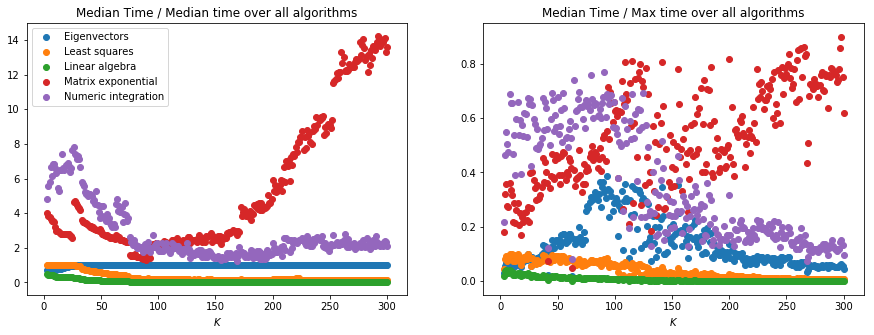

In [27]:
import matplotlib.pyplot as plt

median_times = df.groupby("K")["time"].median()

fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

ax = axarr[0]
for algorithm, dataframe  in df.groupby("algorithm"):
    data = [(K, data["time"].median() / median_times[K]) for K, data in dataframe.groupby("K")]
    ax.scatter(*zip(*data), label=algorithm)
ax.set_title("Median Time / Median time over all algorithms")
ax.set_xlabel("$K$")
ax.legend()

max_times = df.groupby("K")["time"].max()

ax = axarr[1]
for algorithm, dataframe  in df.groupby("algorithm"):
    data = [(K, data["time"].median() / max_times[K]) for K, data in dataframe.groupby("K")]
    ax.scatter(*zip(*data), label=algorithm)
ax.set_title("Median Time / Max time over all algorithms")
ax.set_xlabel("$K$");

#### Conclusion

Comparing all these approaches is seems like the faster way to compute the stationary vector for a continuous time Markov chain is as a direct solution of a linear algebraic system.

Some caveats:

- We have considered a very structered matrix that corresponds to a queueing system: perhaps the sparse nature of the matrix implies this conclusion does not extend to all continuous Markov chains.
- We have only gone up to matrices of size 300.
- For some systems, writing down the state space itself can have a high computational memory cost (indeed at some times it's not even possible). In those cases a simulation approach is actually quite a good way to do this as we can let the simulation explore the state space at will, the python library [ciw](http://ciw.readthedocs.io/en/latest/) is one piece of software with which to do this.